In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, cross_val_score, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import pickle
import os
import shap as shap

In [2]:
df = pd.read_csv('./datasets/ds.raw.csv')

y = df.Class
X = df.drop("Class" ,axis=1)

cw = compute_class_weight('balanced', np.unique(y), y)
cw_dic = {i:j for i,j in zip(np.unique(y), cw)}
scaler = StandardScaler()

clf = RandomForestClassifier(n_estimators=100, class_weight=cw_dic)

In [3]:
# Load only the preselected features
selected = ["prob", "np_DVnpu(c0)", "np_DUccoat(c1)", "np_DPnpu(c3)", "d_DMw(c0)", "d_DALOGP(c0)", "d_DPSA(c0)", "d_DMw(c1)", "d_DALOGP(c1)", "d_DPSA(c1)", "d_DMw(c2)", "d_DALOGP(c2)", "d_DPSA(c2)", "d_DMw(c3)", "d_DALOGP(c3)", "d_DPSA(c3)", "d_DMw(c4)", "d_DALOGP(c4)", "d_DPSA(c4)", "d_DMw(c5)", "d_DALOGP(c5)", "d_DPSA(c5)", "d_DMw(c6)", "d_DALOGP(c6)", "d_DPSA(c6)", "np_DVnpu(c2)", "np_DPnpu(c4)"]
X = df[selected]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1,stratify=y) #, random_state=42)

In [5]:
scaler.fit(X_train)
scaled_test = scaler.transform(X_test[X_test.columns])
X_test = pd.DataFrame(scaled_test, index=X_test.index, columns=X_test.columns)
scaled_train = scaler.transform(X_train[X_train.columns])
X_train = pd.DataFrame(scaled_train, index=X_train.index, columns=X_train.columns)

In [6]:
#if os.path.isfile("./model.bin"):
#    with open("./model.bin", "rb") as file:
#        clf = pickle.load(file)
#else:
#    clf.fit(X_train, Y_train)
#    with open("./model.bin","wb") as file:
#        pickle.dump(clf, file)

In [7]:
%%time
clf.fit(X_train, y_train)

CPU times: user 1min 19s, sys: 118 ms, total: 1min 19s
Wall time: 1min 20s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.637780249609666,
                                     1: 2.3144835758989744},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [8]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.9925780695766259

## Individual shap value plot.

In [9]:
def get_random_index(Y_test, n):
    """
    Obtiene n
    """
    indices1 = Y_test.index[np.random.choice(np.argwhere(Y_test.values == 1).flatten(),size=n,replace=False)]
    indices0 = Y_test.index[np.random.choice(np.argwhere(Y_test.values == 0).flatten(),size=n,replace=False)]
    indices = pd.Index.union(indices0,indices1)
    return indices

In [61]:
while True:
    indices = get_random_index(y_test,6)
    S = X_test.loc[indices]
    X_output = S.copy()
    X_output.loc[:,'predict'] = clf.predict(S)
    # make sure all the predictions are correct
    if (X_output.predict == y_test.loc[indices]).all():break

In [62]:
%%time
shap.initjs()
explainerModel = shap.TreeExplainer(model=clf)#, data=shap.sample(X_test, 100))
shap_values_Model = explainerModel.shap_values(S)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


CPU times: user 14 s, sys: 39.7 ms, total: 14 s
Wall time: 14.1 s


In [29]:
def force_plot_aux(explainerModel, shap_values_Model, scaler, S, i):
    f = shap.force_plot(explainerModel.expected_value[1],
                shap_values_Model[1][i],
                pd.DataFrame(np.array([[round(value, 4) for value in scaler.inverse_transform(S.iloc[[i]])[0]]]),
                             columns=S.columns),
                show=False, matplotlib=True)
    f.savefig("./results/force_plot_"+str(i)+".png", bbox_inches='tight', transparent=True, dpi=600)
    plt.show()

In [88]:
pd.DataFrame(scaler.inverse_transform(X_test), columns=X_test.columns).mean()

prob               0.215726
np_DVnpu(c0)       0.006496
np_DUccoat(c1)     0.001520
np_DPnpu(c3)       0.738609
d_DMw(c0)         -0.550487
d_DALOGP(c0)      -0.021385
d_DPSA(c0)         0.181951
d_DMw(c1)         -1.000414
d_DALOGP(c1)      -0.016079
d_DPSA(c1)        -0.055826
d_DMw(c2)        -10.001640
d_DALOGP(c2)      -0.219443
d_DPSA(c2)         0.010390
d_DMw(c3)         -1.036045
d_DALOGP(c3)      -0.017061
d_DPSA(c3)        -0.056088
d_DMw(c4)         -0.641881
d_DALOGP(c4)      -0.016111
d_DPSA(c4)         0.017493
d_DMw(c5)         -9.072555
d_DALOGP(c5)      -0.040423
d_DPSA(c5)        -1.901923
d_DMw(c6)         -1.037011
d_DALOGP(c6)      -0.016481
d_DPSA(c6)        -0.081988
np_DVnpu(c2)       0.167042
np_DPnpu(c4)       0.603173
dtype: float64

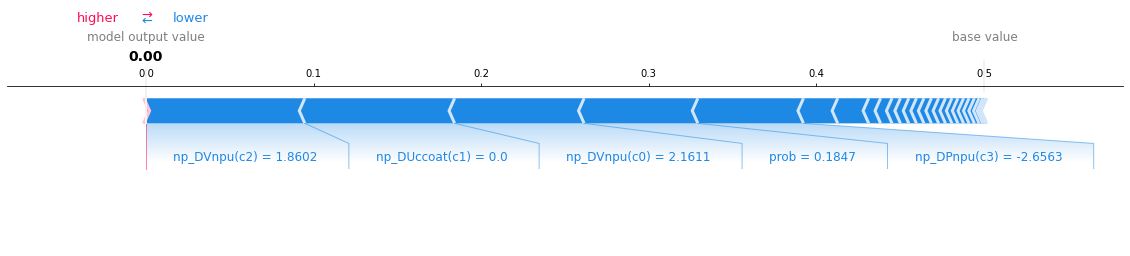

In [30]:
force_plot_aux(explainerModel, shap_values_Model, scaler, S, 0)

Description for the current image:  
np_DVnpu(c2) is significantly higher than the mean value (0.167)  
np_DUccoat(c1) is almost the mean value (0.0015)  
np_DVnpu(c0) is significantly higher than the mean value (0.0065)  
prob is lower than the mean value (0.2157)  
np_DPnpu(c3) is significantly lower than the mean value (0.7386)  

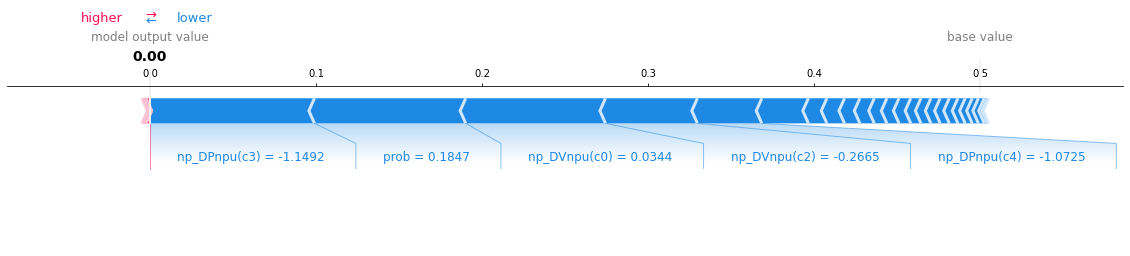

In [40]:
force_plot_aux(explainerModel, shap_values_Model, scaler, S, 1)

Description for the current image:  
np_DPnpu(c3) is lower than the mean value (0.7386)   
prob is a lower than the mean value (0.2157)  
np_DVnpu(c0) is lower than the mean value (0.0065)  
np_DVnpu(c2) is lower than the mean value (0.167)  
np_DPnpu(c4) is lower than the mean value (0.6031)

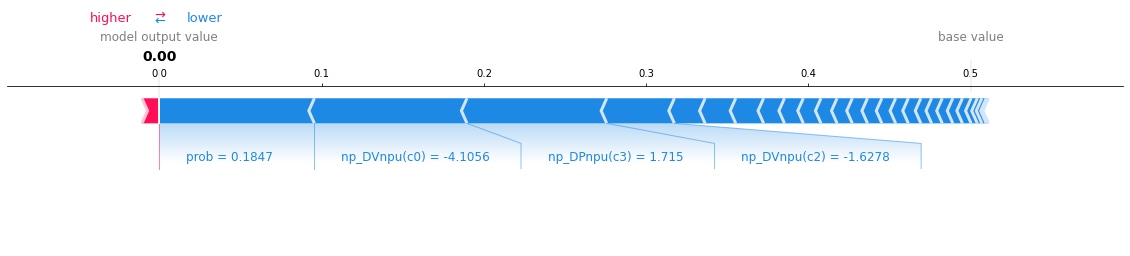

In [59]:
force_plot_aux(explainerModel, shap_values_Model, scaler, S, 2)

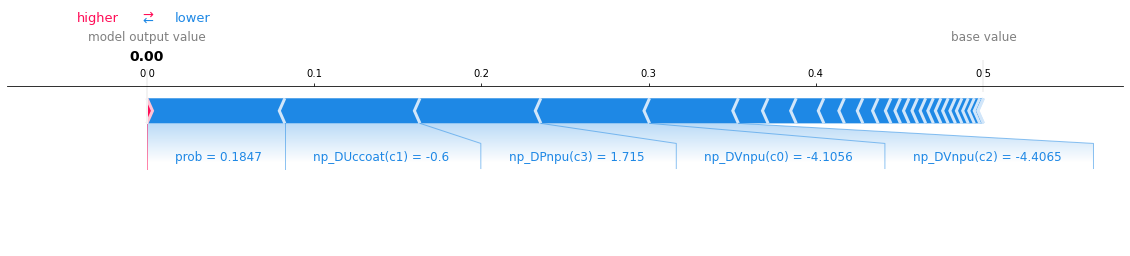

In [63]:
force_plot_aux(explainerModel, shap_values_Model, scaler, S, 3)

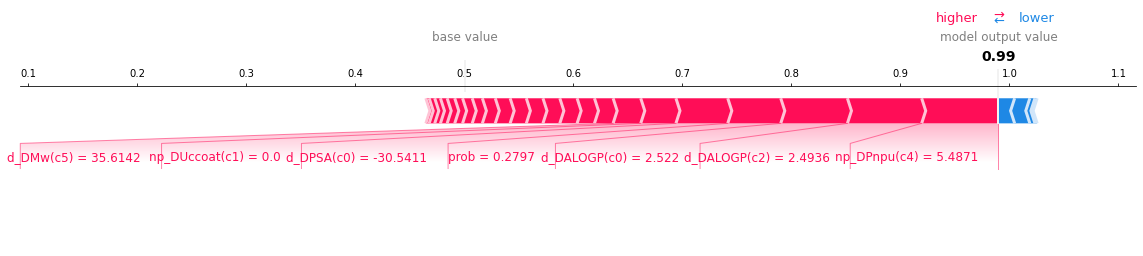

In [56]:
force_plot_aux(explainerModel, shap_values_Model, scaler, S, 4)

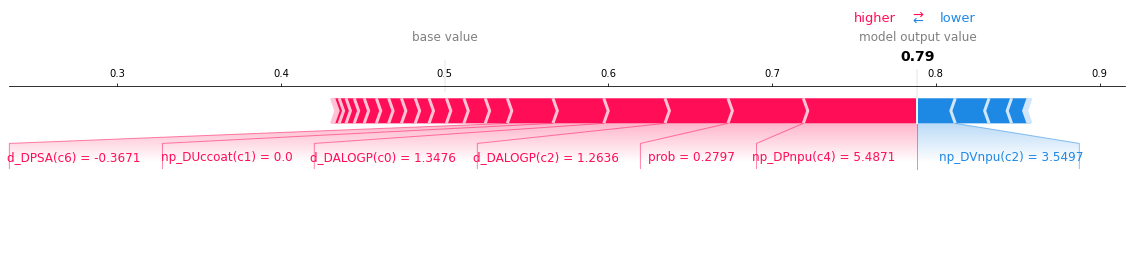

In [39]:
force_plot_aux(explainerModel, shap_values_Model, scaler, S, 5)

Description for the current image:  
d_DALOGP(c0) is higher than the mean value (-0.2194)  
d_DALOGP(c2) is higher than the mean value (-0.0213)  
prob is higher than the mean value (0.2157)  
np_DPnpu(c4) is significantly higher than the mean value (0.6031)  
----
np_DVnpu(c2) is significantly higher than the mean value (0.167)

In [71]:
# Small sample size for testing purposes
# increase size if you have time to run the computation
sample_size = 50
S = X_test
X_output = S.copy()
X_output.loc[:,'predict'] = clf.predict(S)
X_output = X_output[X_output.predict == y_test]
y_output = y_test.loc[X_output.index]
indices = get_random_index(y_output,sample_size)
S = S.loc[indices]
X_output = X_output.loc[indices]
y_output = y_output.loc[indices]

In [72]:
%%time
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(S)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


CPU times: user 2min 20s, sys: 377 ms, total: 2min 21s
Wall time: 2min 21s


In [85]:
shap.force_plot(explainerModel.expected_value[1], shap_values[1], 
                pd.DataFrame(scaler.inverse_transform(S), columns=S.columns))

## Summary Plot

In [17]:
sample_size = 500
S = X_test
X_output = S.copy()
X_output.loc[:,'predict'] = clf.predict(S)
X_output = X_output[X_output.predict == y_test]
y_output = y_test.loc[X_output.index]
indices = get_random_index(y_output,sample_size)
S = S.loc[indices]
X_output = X_output.loc[indices]
y_output = y_output.loc[indices]

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


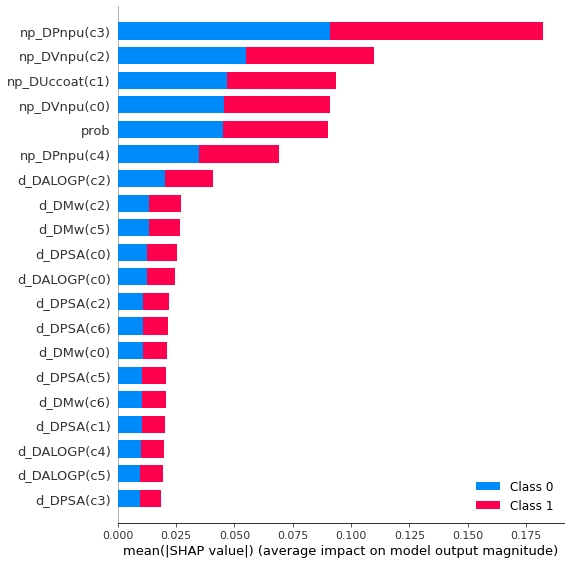

CPU times: user 40min 58s, sys: 4.3 s, total: 41min 2s
Wall time: 41min 4s


In [18]:
%%time
# Solo acepta el plot de barras para las clasificaciones binarias
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(S)
shap.summary_plot(shap_values, S, plot_type="bar")

<Figure size 432x288 with 0 Axes>

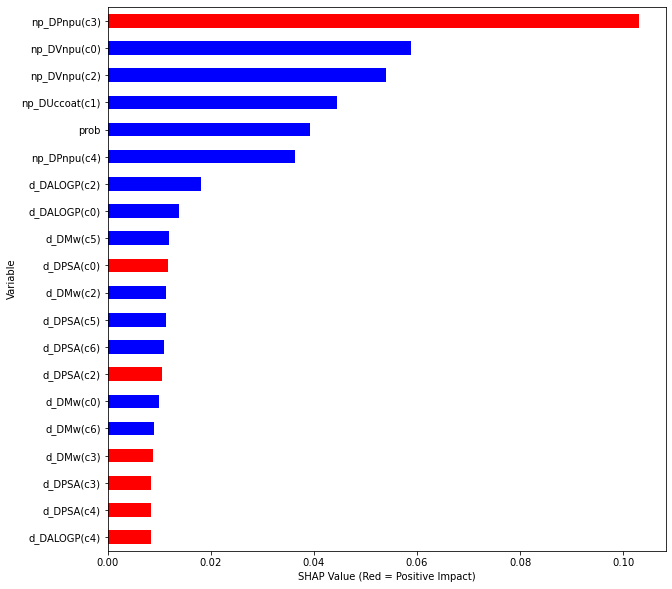

In [74]:
# Commented because it is not coherent, maybe because it is not appropriate for classification problems
# # Color the bars corresponding to correlation
# def ABS_SHAP(df_shap,df):
#     #import matplotlib as plt
#     # Make a copy of the input data
#     shap_v = pd.DataFrame(df_shap)
#     feature_list = df.columns
#     shap_v.columns = feature_list
#     df_v = df.copy().reset_index().drop('index',axis=1)
    
#     # Determine the correlation in order to plot with different colors
#     corr_list = list()
#     for i in feature_list:
#         b = np.corrcoef(shap_v[i],df_v[i])[1][0]
#         corr_list.append(b)
#     corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
#     # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
#     corr_df.columns  = ['Variable','Corr']
#     corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
#     # Plot it
#     shap_abs = np.abs(shap_v)
#     k=pd.DataFrame(shap_abs.mean()).reset_index()
#     k.columns = ['Variable','SHAP_abs']
#     k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
#     k2 = k2.sort_values(by='SHAP_abs',ascending = True)
#     k2 = k2[7:]
#     colorlist = k2['Sign']
#     ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(10,10),legend=False)
#     ax.set_xlabel("SHAP Value (Red = Positive Impact)")

# plt.figure()
# ABS_SHAP(shap_values[0],S)
# plt.show()

## Dependence plot

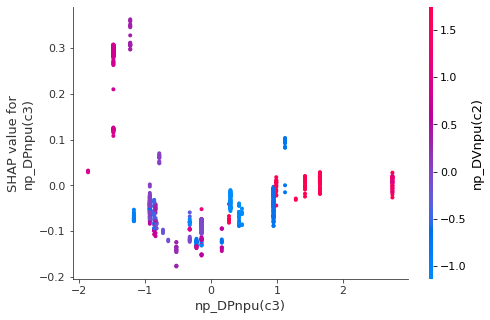

In [19]:
shap.dependence_plot("np_DPnpu(c3)", shap_values[1], S)

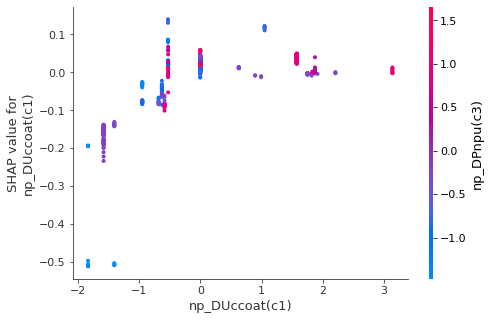

In [20]:
shap.dependence_plot("np_DUccoat(c1)", shap_values[1], S)

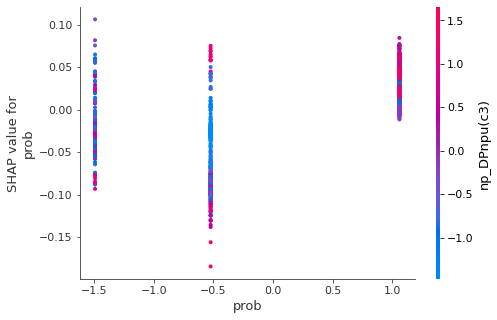

In [21]:
shap.dependence_plot("prob", shap_values[1], S)

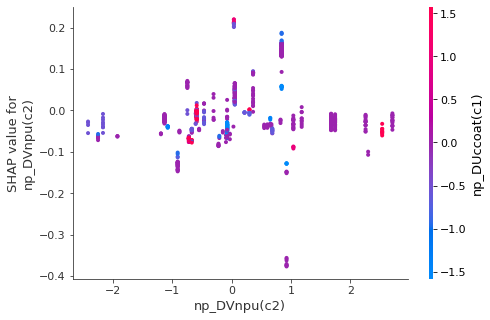

In [22]:
shap.dependence_plot("np_DVnpu(c2)", shap_values[1], S)

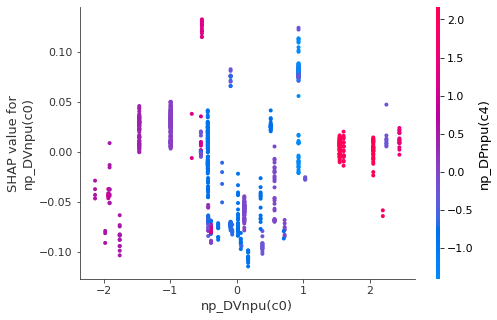

In [23]:
shap.dependence_plot("np_DVnpu(c0)", shap_values[1], S)

In [24]:
# f = plt.figure()
# shap.summary_plot(shap_values,S )
# f.savefig("./summary_plot1.png", bbox_inches='tight', dpi=600)